In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(0);

┌ Info: Precompiling LargeMessageCollider [7f03d5f0-357e-4842-abc9-7001c0bc8a0e]
└ @ Base loading.jl:1278


In [2]:
# Generate Synthetic Data
N = 50 # number of data points

p1, p2, p3 = Normal(-10.0, sqrt(1/0.25)), Normal(-3.0, sqrt(1/0.5)), Normal(7.5, sqrt(1/2))

real_mix = MixtureModel(Normal[p1,p2,p3], [0.2, 0.5, 0.3])

data = rand(real_mix, N);

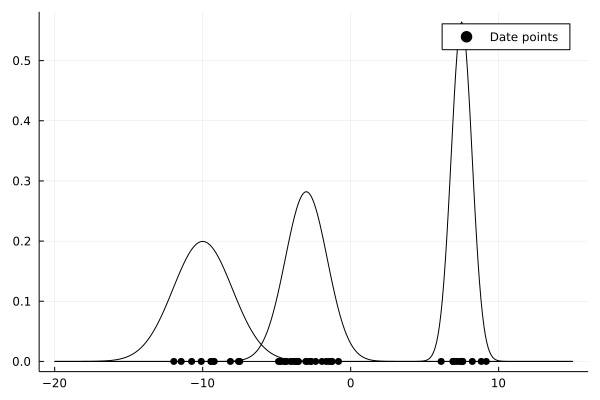

In [3]:
scatter(data,zeros(N), color=:black, label="Date points")
plot!(collect(-20:0.1:15), pdf.(p1,collect(-20:0.1:15)), color=:black, label=false)
plot!(collect(-20:0.1:15), pdf.(p2,collect(-20:0.1:15)), color=:black, label=false)
plot!(collect(-20:0.1:15), pdf.(p3,collect(-20:0.1:15)), color=:black, label=false)

In [4]:
# Priors
pm1, pm2, pm3 = Normal(mean(data)-std(data),10), Normal(mean(data),10), Normal(mean(data)+std(data),10)
pw1, pw2, pw3 = Gamma(1,1), Gamma(1,1), Gamma(1,1)
pϕ = Dirichlet([0.1,0.1,0.1])
;

In [5]:
# Initial recognition factors
qm = [pm1, pm2, pm3]
qw = [pw1, pw2, pw3]
qϕ = pϕ
qz = Array{Categorical}(undef,N)
for n=1:N
    qz[n] = Categorical(3)
end
;

In [6]:
# Inference

for i=1:20
    # update qz
    for n=1:N
        vmp = normalmix(data[n],nothing,qm,qw)
        qz[n] = collide(categorical(nothing,qϕ),vmp)
    end

    # update qϕ
    vmp = categorical.(qz,nothing)
    qϕ = pϕ
    for n=1:N
        qϕ *= vmp[n]
    end

    # update qm
    qm = [pm1, pm2, pm3]
    for n=1:N
        vmp = normalmix(data[n],qz[n],nothing,qw)
        qm = collide.(qm, vmp)
    end

    # update qw
    qw = [pw1, pw2, pw3]
    for n=1:N
        vmp = normalmix(data[n],qz[n],qm,nothing)
        qw = collide.(qw, vmp)
    end
    
    # calculate Free Energy
    F = -entropy(qϕ) - sum(entropy.(qm)) - sum(entropy.(qw))
    F = F + cross_entropy(qϕ, pϕ) + sum(cross_entropy.(qm, [pm1, pm2, pm3])) + sum(cross_entropy.(qw, [pw1, pw2, pw3]))
    for n=1:N
        F -= entropy(qz[n])
        F += cross_entropy(qϕ, qz[n])
        F += normalmix(data[n],qz[n],qm,qw)
    end
    @show F
end

F = 150.4099987382516
F = 148.52725291211638
F = 148.18330000224498
F = 148.15177309138585
F = 148.1507674076474
F = 148.1507446987559
F = 148.15074420895715
F = 148.150744198327
F = 148.15074419809395
F = 148.1507441980889
F = 148.15074419808863
F = 148.15074419808883
F = 148.15074419808866
F = 148.15074419808855
F = 148.1507441980888
F = 148.15074419808874
F = 148.1507441980886
F = 148.15074419808883
F = 148.1507441980888
F = 148.1507441980886


In [7]:
qϕ

Dirichlet{Float64,Array{Float64,1},Float64}(alpha=[11.08064731464877, 26.11935268535202, 13.09999999999922])

In [8]:
qm

3-element Array{Normal{Float64},1}:
 Normal{Float64}(μ=-9.5270466450554, σ=0.42319607970922846)
 Normal{Float64}(μ=-3.229065070933882, σ=0.23772177787848844)
 Normal{Float64}(μ=7.524653156369831, σ=0.2341714244746981)

In [9]:
qw

3-element Array{Gamma{Float64},1}:
 Gamma{Float64}(α=6.490323657324386, θ=0.0782066951803135)
 Gamma{Float64}(α=14.009676342675998, θ=0.0485167805430113)
 Gamma{Float64}(α=7.499999999999609, θ=0.18693446207286663)

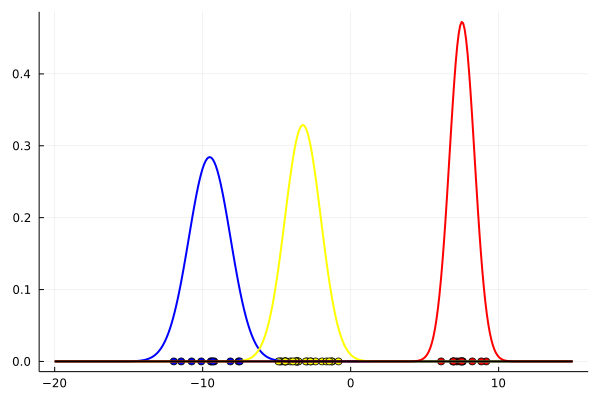

In [10]:
# Estimates
# We draw mixture distributions by using mean of approximate distributions

color_list = [:blue, :yellow, :red]
scatter((data[1],0),color=color_list[argmax(qz[1].p)], legend=false)
for n=2:N
    scatter!((data[n],0),color=color_list[argmax(qz[n].p)])
end
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[1]),sqrt(1/mean(qw[1]))),collect(-20:0.1:15)), color=:blue,lw=2)
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[2]),sqrt(1/mean(qw[2]))),collect(-20:0.1:15)), color=:yellow,lw=2)
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[3]),sqrt(1/mean(qw[3]))),collect(-20:0.1:15)), color=:red,lw=2)
plot!(collect(-20:0.1:15),zeros(length(collect(-20:0.1:15))),color=:black, lw=2)